### OBJECTIVE: Super Store Sales Prediction (Time Series Data)
We will predict sales for the thousands of product families sold at Favorita stores located in Ecuador.   
The training data (Time Series data) includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files with supplementary information are also given such as - Number of transactions, holidays list, oil price etc, that may be useful in building Models.

The **evaluation metric** for this competition is **Root Mean Squared Logarithmic Error**.

<center>
    <img src="https://www.artefact.com//wp-content/uploads/2021/03/ARTICLE.jpeg" width="400">
</center>

## GITHUB Repository URL
### https://github.com/rakesh82rawat/RR2-EDA_AutoCompany

## Kaggle Code URL
### https://www.kaggle.com/code/rakesh82rawat/rr2-eda-abcmotors/edit/run/130323916

  

In [1]:
# importing key libraries

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt

import sklearn
import statsmodels

import warnings
warnings.filterwarnings("ignore")


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


**FEATURE DESCRIPTION**

**Features** : store_nbr, family, and onpromotion as well as the target sales.  
**store_nbr** identifies the store at which the products are sold.  
**family** identifies the type of product sold.  
**sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).    
**onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.  

### Reading all Datasets

In [2]:
# Import files Using data in DATAFRAME FORMAT (Preferred)
# from local file

train=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')  # Here the index will be auto given as 0,1,2,3...
test=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
holidays_events=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
oil=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
stores=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

display('train',train.shape)
display(train.head(2))
display(train.tail(2))

display('test',test.shape)
display(test.head(2))

display('holidays_events',holidays_events.shape)
display(holidays_events.head(2))

display('oil',oil.shape)
display(oil.head(2))

display('stores',stores.shape)
display(stores.head(2))

display('transactions',transactions.shape)
display(transactions.head(2))



#> date range start: 01-01-2013  ;  end: 15-08-2017

'train'

(3000888, 6)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0


,id,date,store_nbr,family,sales,onpromotion
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.0,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.0,0


'test'

(28512, 5)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0


'holidays_events'

(350, 6)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


'oil'

(1218, 2)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14


'stores'

(54, 5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13


'transactions'

(83488, 3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111


In [3]:
train.info(verbose=True, null_counts=True)  
#> Note that date is in object format and sales in float format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           3000888 non-null  int64  
 1   date         3000888 non-null  object 
 2   store_nbr    3000888 non-null  int64  
 3   family       3000888 non-null  object 
 4   sales        3000888 non-null  float64
 5   onpromotion  3000888 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


### Combining all datasets as one, into train & test 


In [4]:
# oil -> train, test
oil.rename(columns={'dcoilwtico':'oil_price'}, inplace=True)
train=pd.merge(train, oil, on='date', how='left')
test=pd.merge(test, oil, on='date', how='left') 

In [5]:
train.head(2)

,id,date,store_nbr,family,sales,onpromotion,oil_price
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN


In [6]:
# stores -> train, test
train=pd.merge(train, stores, on='store_nbr', how='left')
test=pd.merge(test, stores, on='store_nbr', how='left') 

In [7]:
train.head(2)

,id,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13


In [8]:
# holiday_events

# NOTE: Pay special attention to the transferred column. 
  #A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government.
  #A transferred day is more like a normal day than a holiday. 
  #To find the day that it was actually celebrated, look for the corresponding row where type is Transfer.

#> Hence, Its a normal working day if (type=work day) OR (transferred=True)
    
holidays_events.sample(5)

,date,type,locale,locale_name,description,transferred
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
18,2012-10-07,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False
137,2014-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
96,2014-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
28,2012-12-05,Additional,Local,Quito,Fundacion de Quito-1,False


In [9]:
holidays_events['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [10]:
# Considering the type and transferred conditions, we create the special days that represent Non-working days

condition=(holidays_events.transferred == True) | (holidays_events.type=='Work Day')

# Dropping from holiday_events list the working days listed down in 'condition'
special_days=holidays_events.drop(holidays_events[condition].index)

# Dropping not required columns after special_days created
special_days=special_days.drop(['type','description','transferred'],axis=1)
special_days['special_days']=1

# Dropping duplicate dates in special_days list
special_days=special_days.drop(special_days[special_days.date.duplicated()].index)


In [11]:
special_days.sample(5)

,date,locale,locale_name,special_days
67,2013-08-10,National,Ecuador,1
37,2012-12-25,National,Ecuador,1
167,2015-04-12,Local,Cuenca,1
295,2016-12-26,National,Ecuador,1
16,2012-08-24,Local,Ambato,1


In [12]:
# Splitting holiday_events into Local, Regional, and National
national=special_days[special_days.locale == 'National']
Regional=special_days[special_days.locale == 'Regional']
Local=special_days[special_days.locale == 'Local']

In [13]:
display(national.head(2)),
display(Regional.head(2)),
display(Local.head(2))

,date,locale,locale_name,special_days
14,2012-08-10,National,Ecuador,1
20,2012-10-12,National,Ecuador,1


,date,locale,locale_name,special_days
1,2012-04-01,Regional,Cotopaxi,1
7,2012-06-25,Regional,Imbabura,1


,date,locale,locale_name,special_days
0,2012-03-02,Local,Manta,1
2,2012-04-12,Local,Cuenca,1


In [14]:
# National holidays -> train,test
national=national.drop(['locale','locale_name'],axis=1)
train=pd.merge(train,national, on='date',how='left')
test=pd.merge(test,national, on='date',how='left') 

In [15]:
train.sample(5)

,id,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type,cluster,special_days
1741277,1741277,2015-09-07,16,SEAFOOD,5.000,0,NaN,Santo Domingo,Santo Domingo de los Tsachilas,C,3,NaN
2647507,2647507,2017-01-29,43,HOME AND KITCHEN II,30.000,1,NaN,Esmeraldas,Esmeraldas,E,10,NaN
2403158,2403158,2016-09-13,37,SEAFOOD,23.665,1,44.91,Cuenca,Azuay,D,2,NaN
1643113,1643113,2015-07-14,12,EGGS,41.000,0,53.05,Latacunga,Cotopaxi,C,15,NaN
2088455,2088455,2016-03-20,8,HOME APPLIANCES,2.000,0,NaN,Quito,Pichincha,D,8,NaN


In [16]:
# Putting special days=1 in train and test for regional(state) holidays
for i,j in zip(Regional.date, Regional.locale_name):
    train['special_days'][(train.date==i)&(train.state==j)]=1 

for i,j in zip(Regional.date, Regional.locale_name):
    test['special_days'][(test.date==i)&(test.state==j)]=1 

In [17]:
# Putting special days=1 in train and test for Local(city) holidays
for i,j in zip(Local.date, Local.locale_name):
    train['special_days'][(train.date==i)&(train.city==j)]=1 

for i,j in zip(Local.date, Local.locale_name):
    test['special_days'][(test.date==i)&(test.city==j)]=1 

In [18]:
train.sample(5)

,id,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type,cluster,special_days
2301708,2301708,2016-07-18,40,MEATS,127.247,0,45.23,Machala,El Oro,C,3,NaN
1235837,1235837,2014-11-26,34,LAWN AND GARDEN,0.000,0,73.70,Guayaquil,Guayas,B,6,NaN
2597103,2597103,2017-01-01,3,BEVERAGES,0.000,0,NaN,Quito,Pichincha,D,8,NaN
2308041,2308041,2016-07-22,19,LINGERIE,0.000,0,43.41,Guaranda,Bolivar,C,15,NaN
2114537,2114537,2016-04-04,39,PREPARED FOODS,87.228,0,34.30,Cuenca,Azuay,B,6,NaN


In [19]:
# Missing values in train and test sets
display('train',train.isna().sum()[train.isna().sum()>0])
display('test', test.isna().sum()[test.isna().sum()>0]) 

'train'

oil_price        928422
special_days    2766390
dtype: int64

'test'

oil_price        7128
special_days    28446
dtype: int64

In [20]:
# Missing values imputation for train and test (bfill imputes the missing value with next available value)
train['oil_price']=train['oil_price'].fillna(method='bfill')
test['oil_price']=test['oil_price'].fillna(method='bfill') 

In [21]:
# Missing values imputation for special_days(impute with 0 - representing work days)
train['special_days']=train['special_days'].fillna(0)
test['special_days']=test['special_days'].fillna(0) 

In [22]:
# recheck Missing values 
display('train',train.isna().sum()[train.isna().sum()>0])
display('test', test.isna().sum()[test.isna().sum()>0]) 

#> No missing values found

'train'

Series([], dtype: int64)

'test'

Series([], dtype: int64)

In [23]:
train.sample(5) 

,id,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type,cluster,special_days
459965,459965,2013-09-16,15,FROZEN FOODS,13.00,0,106.54,Ibarra,Imbabura,C,15,0.0
2895725,2895725,2017-06-17,9,DAIRY,1138.00,34,44.24,Quito,Pichincha,B,6,0.0
2268962,2268962,2016-06-30,22,HARDWARE,2.00,0,48.27,Puyo,Pastaza,C,7,0.0
2882190,2882190,2017-06-10,29,BEVERAGES,3369.00,25,46.10,Guayaquil,Guayas,E,10,0.0
77413,77413,2013-02-13,30,POULTRY,66.51,0,97.03,Guayaquil,Guayas,C,3,0.0


In [24]:
# Dropping useless columns

train=train.drop(columns=['city','state','cluster'],axis=1)       # not store_nbr (RR)
test=test.drop(columns=['city','state','cluster'],axis=1) 

In [25]:
train.sample(5)

,id,date,store_nbr,family,sales,onpromotion,oil_price,type,special_days
2415713,2415713,2016-09-20,4,HARDWARE,1.0,0,43.85,D,0.0
336971,336971,2013-07-09,14,DAIRY,162.0,0,103.46,C,0.0
224081,224081,2013-05-06,46,FROZEN FOODS,181.0,0,95.80,A,0.0
2330256,2330256,2016-08-03,41,PLAYERS AND ELECTRONICS,12.0,0,40.80,D,0.0
1607032,1607032,2015-06-23,49,SCHOOL AND OFFICE SUPPLIES,3.0,0,61.05,A,0.0


In [26]:
test.sample(5)

# prepare data for model fit on train dataset

,id,date,store_nbr,family,onpromotion,oil_price,type,special_days
15829,3016717,2017-08-24,52,"LIQUOR,WINE,BEER",2,47.24,A,0.0
9857,3010745,2017-08-21,35,MAGAZINES,0,47.39,C,0.0
5443,3006331,2017-08-19,11,SCHOOL AND OFFICE SUPPLIES,6,47.39,B,0.0
26844,3027732,2017-08-31,12,HOME AND KITCHEN I,0,47.26,C,0.0
16746,3017634,2017-08-25,29,HOME AND KITCHEN I,1,47.65,E,0.0


In [27]:
# prepare data for model fit on train dataset
# get dummies for family and type in train and test sets

train = pd.get_dummies(train, columns=['family', 'type'])
test = pd.get_dummies(test, columns=['family', 'type'])

train.sample(5)
test.sample(5)

,id,date,store_nbr,onpromotion,oil_price,special_days,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,type_A,type_B,type_C,type_D,type_E
25787,3026675,2017-08-30,32,0,45.96,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1057,3001945,2017-08-16,39,0,46.80,0.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
11589,3012477,2017-08-22,34,0,47.65,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
28029,3028917,2017-08-31,45,95,47.26,0.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
24803,3025691,2017-08-29,54,0,46.46,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [28]:
#Converting date form to different forms of month, year, day for further analysis

train['month'] = pd.to_datetime(train['date']).dt.month
train['day'] = pd.to_datetime(train['date']).dt.day
train['day_name'] = pd.to_datetime(train['date']).dt.day_name()
train['year'] = pd.to_datetime(train['date']).dt.year
train.sample(3)

,id,date,store_nbr,sales,onpromotion,oil_price,special_days,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,...,family_SEAFOOD,type_A,type_B,type_C,type_D,type_E,month,day,day_name,year
611083,611083,2013-12-09,54,5.000,0,97.10,0.0,0,0,0,...,0,0,0,1,0,0,12,9,Monday,2013
1625609,1625609,2015-07-04,20,107.928,0,52.48,0.0,0,0,0,...,0,0,1,0,0,0,7,4,Saturday,2015
1292253,1292253,2014-12-29,18,5.000,0,53.46,0.0,0,0,0,...,0,0,1,0,0,0,12,29,Monday,2014


In [29]:
#Converting date form to different forms of month, year, day for further analysis

test['month'] = pd.to_datetime(test['date']).dt.month
test['day'] = pd.to_datetime(test['date']).dt.day
test['day_name'] = pd.to_datetime(test['date']).dt.day_name()
test['year'] = pd.to_datetime(test['date']).dt.year
test.sample(3) 

,id,date,store_nbr,onpromotion,oil_price,special_days,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,...,family_SEAFOOD,type_A,type_B,type_C,type_D,type_E,month,day,day_name,year
16493,3017381,2017-08-25,21,0,47.65,0.0,0,0,0,0,...,0,0,1,0,0,0,8,25,Friday,2017
24794,3025682,2017-08-29,54,1,46.46,0.0,0,0,0,0,...,0,0,0,1,0,0,8,29,Tuesday,2017
27990,3028878,2017-08-31,44,0,47.26,0.0,0,0,0,0,...,0,1,0,0,0,0,8,31,Thursday,2017


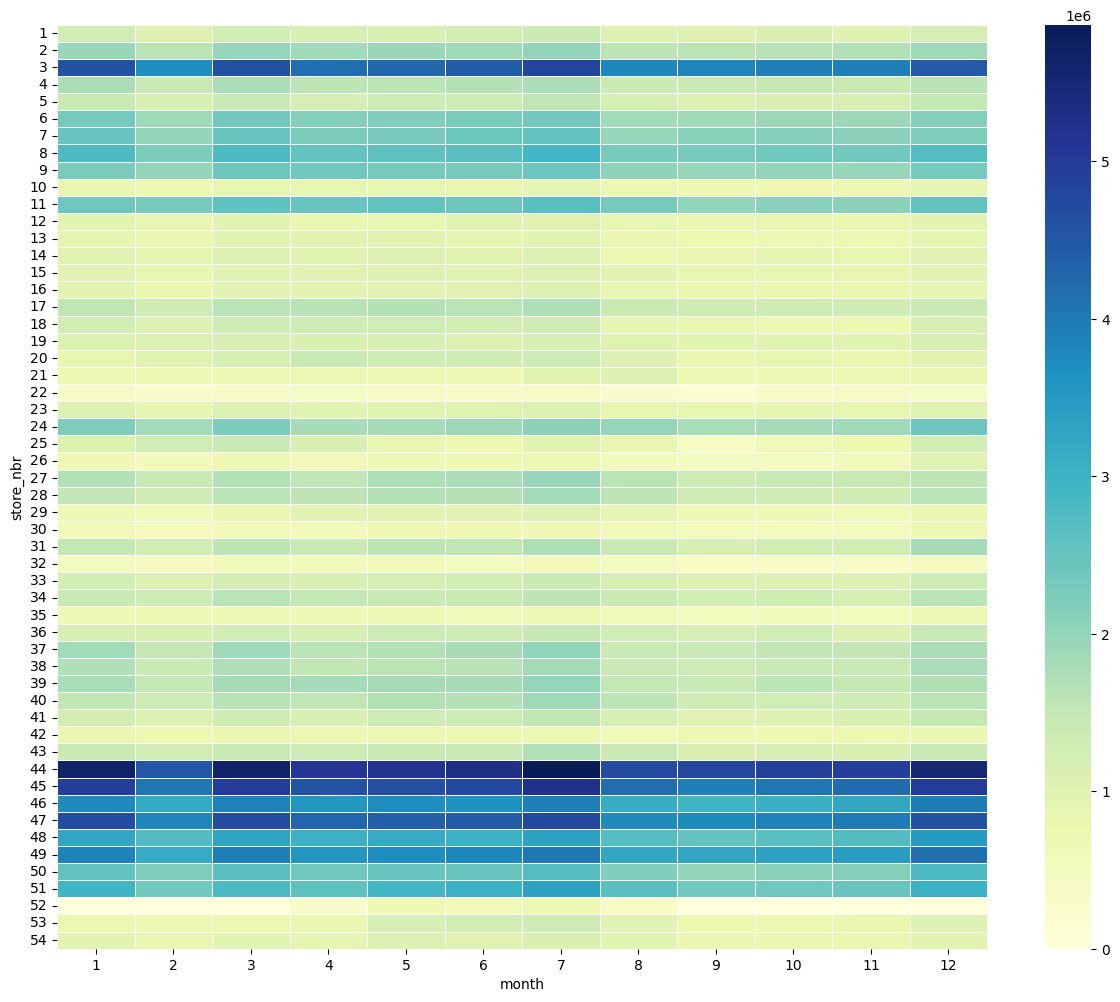

In [30]:
# IMPACT ASSESSMENT OF DAY/MONTH... ON SALES

# checking if any Month having impact on Sales.

table = pd.pivot_table(train, values ='sales', index =['store_nbr'],
                         columns =['month'], aggfunc = np.sum)
fig, ax = plt.subplots(figsize=(15,12))         
sns.heatmap(table, annot=False, linewidths=.5, ax=ax, cmap="YlGnBu")
plt.show()

#> Observations :
# There is no gradual increase of sales for any stores over time. 
  #Almost all stores have same business as previous months

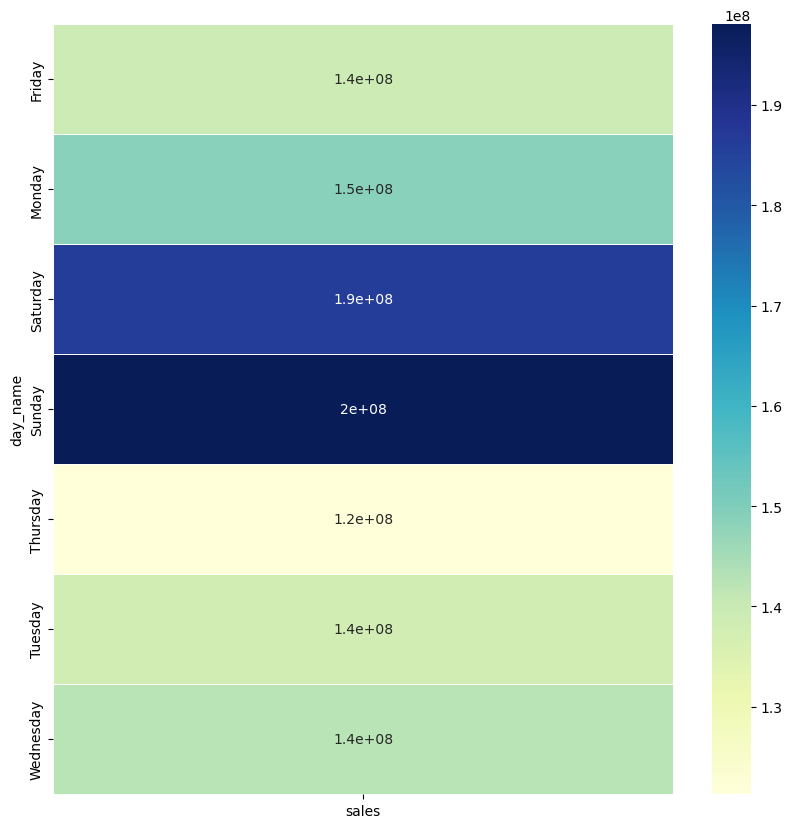

In [31]:
# checking if any Week-day having impact on sales 

table3 = pd.pivot_table(train, values ='sales', index =['day_name'], aggfunc = np.sum)
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(table3, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
plt.show()

#> Observations :
# Weekend sales is always high (will use this information for feature engineering)

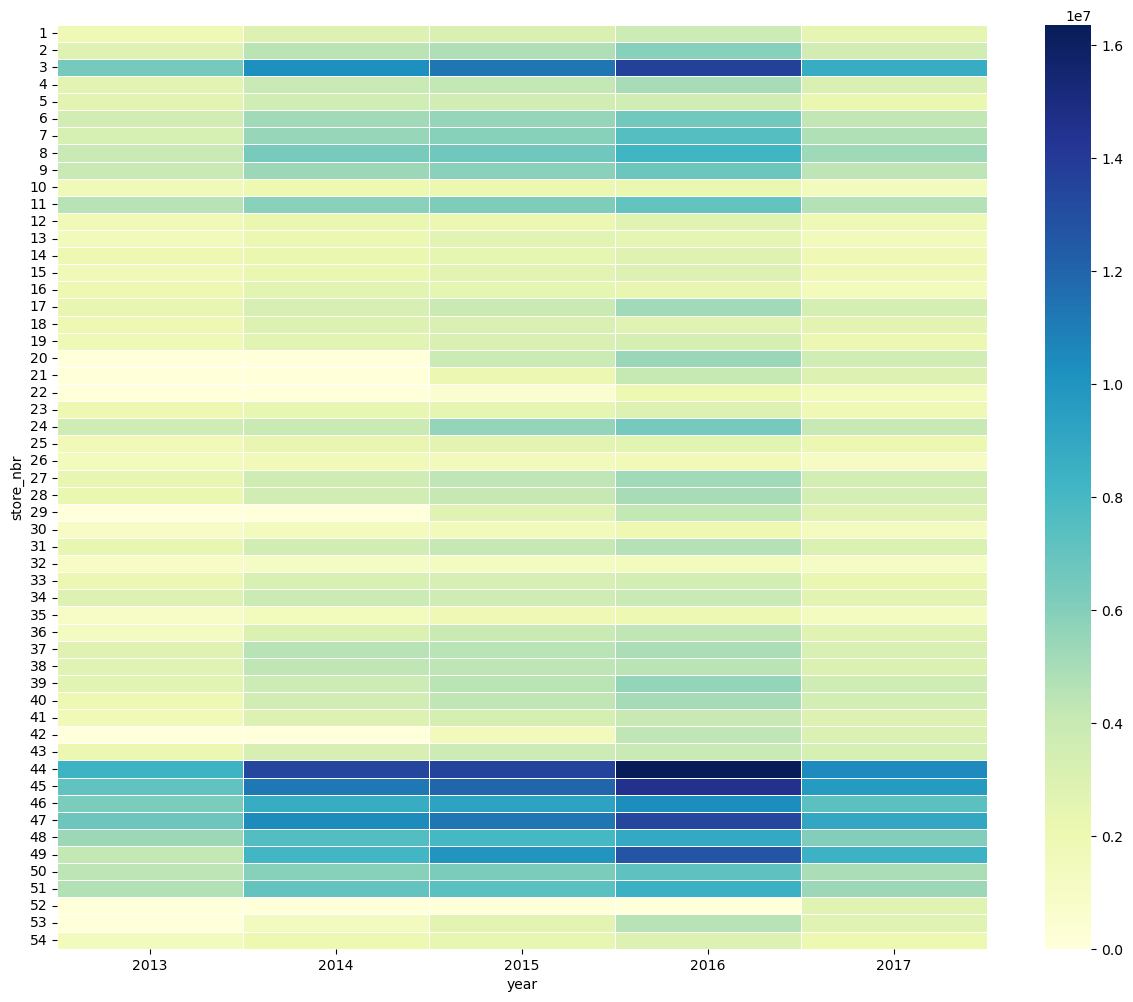

In [32]:
# checking if the sales year have any impact

table_year = pd.pivot_table(train, values ='sales', index =['store_nbr'],
                         columns =['year'], aggfunc = np.sum)

fig, ax = plt.subplots(figsize=(15,12))         
sns.heatmap(table_year, annot=False, linewidths=.5, ax=ax, cmap="YlGnBu")
plt.show()

#> Observations:
# There is a weak co-relation between year and sales

In [33]:
# OUTLIERS

# graph before handling the oulier (taking Store_nbr 5 for sample check)
import plotly.express as px
fig = px.scatter(train[train.store_nbr==5], x="date", y="sales")
fig.show()

In [34]:
# Outliers Treatment for each store

for i in range(1,len(train.store_nbr.unique())+1):
    
    # Filtering out (drop) the rows where the sales value is > 99 percentile of sales value
    val = train[train.store_nbr == i].sales.quantile(0.99)
    train = train.drop(train[(train.store_nbr==i) & (train.sales > val)].index)

In [35]:
# graph after handling the oulier (taking Store_nbr 5 for sample check)
import plotly.express as px
fig = px.scatter(train[train.store_nbr==5], x="date", y="sales")
fig.show()

In [36]:
train.sample(5)

,id,date,store_nbr,sales,onpromotion,oil_price,special_days,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,...,family_SEAFOOD,type_A,type_B,type_C,type_D,type_E,month,day,day_name,year
2568895,2568895,2016-12-15,38,60.000,0,50.90,0.0,0,0,0,...,0,0,0,0,1,0,12,15,Thursday,2016
98295,98295,2013-02-25,17,1.000,0,92.74,0.0,0,0,0,...,0,0,0,1,0,0,2,25,Monday,2013
1753308,1753308,2015-09-13,53,218.000,0,44.07,0.0,0,0,0,...,0,0,0,0,1,0,9,13,Sunday,2015
912901,912901,2014-05-29,23,52.000,0,104.26,0.0,0,0,0,...,0,0,0,0,1,0,5,29,Thursday,2014
2375052,2375052,2016-08-28,49,535.756,1,46.97,0.0,0,0,0,...,0,1,0,0,0,0,8,28,Sunday,2016


In [37]:
# Dropping unwanted columns

train.drop(['id', 'date','day_name'],axis=1, inplace=True)

In [38]:
train.sample(3)

,store_nbr,sales,onpromotion,oil_price,special_days,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,...,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,type_A,type_B,type_C,type_D,type_E,month,day,year
1970672,52,0.0,0,31.22,0.0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,14,2016
1330048,28,10.0,0,46.79,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,19,2015
820070,19,0.0,0,100.43,0.0,0,0,0,0,0,...,0,0,0,0,1,0,0,4,7,2014


## MODEL BUILDING

In [39]:
# Importing Libraries

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn import preprocessing

In [40]:
# Loop through unique store numbers
for i in range(1, len(train.store_nbr.unique()) + 1):  
    temp_df = train[train.store_nbr == i]
    
    # Extract sales column
    sale_out = temp_df[['sales']]
    
    # Calculate maximum value of onpromotion for the current store number
    globals()['max_%s' % i] = temp_df['onpromotion'].max()
    
     # Normalize onpromotion values
    temp_df['onpromotion'] = (temp_df['onpromotion'] / globals()['max_%s' % i])
    temp_df.onpromotion = np.where(temp_df.onpromotion < 0, 0, temp_df.onpromotion)
    
    # Drop unnecessary columns
    temp_df.drop(['sales', 'store_nbr'], axis=1, inplace=True)
    
    # Create and train XGBoost model for current store number
    globals()['model_%s' % i] = XGBRegressor(verbosity=0) 
    globals()['model_%s' % i].fit(temp_df, sale_out)

In [41]:
temp_df.head()

,onpromotion,oil_price,special_days,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,...,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,type_A,type_B,type_C,type_D,type_E,month,day,year
1617,0.0,93.14,1.0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,2013
1618,0.0,93.14,1.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,2013
1619,0.0,93.14,1.0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,1,2013
1620,0.0,93.14,1.0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,2013
1621,0.0,93.14,1.0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1,2013


In [42]:
test=test.drop(['date','day_name'],axis=1)
test.columns

Index(['id', 'store_nbr', 'onpromotion', 'oil_price', 'special_days',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 'month', 'day', 'year'],
      dtype='object')

In [43]:
# Create an empty DataFrame for backup
backup_df_1 = pd.DataFrame()

# Iterate over unique store numbers
for i in range(1,len(train.store_nbr.unique())+1):
    temp_df = test[test.store_nbr == i]
    
    # Scale the 'onpromotion' column by dividing it by the corresponding maximum value
    temp_df['onpromotion'] = (temp_df['onpromotion']/globals()['max_%s' % i])
    
    # Set any negative values in 'onpromotion' to 0
    temp_df.onpromotion = np.where(temp_df.onpromotion<0, 0, temp_df.onpromotion)
    
     # Save the 'id' column before dropping it
    save_id = temp_df[['id']].reset_index()
    
    # Drop unnecessary columns
    temp_df.drop(['id','store_nbr'],axis=1, inplace=True)
    submit = globals()['model_%s' % i].predict(temp_df)
    save_id['sales'] = submit
    
    # Create a DataFrame with the 'sales' column
    df11 = pd.DataFrame(submit, columns = ['sales'])
    
    # Concatenate the save_id DataFrame and df11 DataFrame
    backup_df = pd.concat([save_id[['id']], df11], axis = 1, ignore_index = True)
   
    # Append backup_df to backup_df_1
    backup_df_1 = backup_df_1.append(backup_df, ignore_index=True)

# Rename the columns of backup_df_1
backup_df_1.rename(columns={0 : "id", 1 : "sales"}, inplace=True, errors='raise')

# Merge test DataFrame with backup_df_1 on 'id' column
test = pd.merge(test, backup_df_1, on='id', how='left') 

In [44]:
backup_df_1.head(4)

,id,sales
0,3000888,4.371248
1,3000889,0.458014
2,3000890,21.434444
3,3000891,1913.661133


In [45]:
sample_df1 = test[['id', 'sales']]
sample_df1.sales = np.where(sample_df1.sales<0, 0, sample_df1.sales)
sample_df1.head(3)

,id,sales
0,3000888,4.371248
1,3000889,0.458014
2,3000890,21.434444


In [46]:
# Converting sample_df1 file for final submission
sample_df1.to_csv('submission1.csv' , index = False)

**RMSLE score** obtained upon submission : **1.03**